In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn import Sigmoid

d:\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import imgshow and plot show
#impot class SiameseNetworkDataset 
from utils.plot_helpers import imshow, show_plot
from utils.siamese_dataset import SiameseNetworkDataset
import os

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Preparing the data

In [4]:
#Load the training dataset
transformation = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                          std=[0.229, 0.224, 0.225]),
                                     transforms.RandomHorizontalFlip()
                                    ])
# transformation = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.ToTensor(),
#                                      transforms.RandomHorizontalFlip()
#                                     ])

folder_datatrain = SiameseNetworkDataset(root_path=os.path.join('dataset_jpg1','train'), 
                                         transform=transformation)

train_size = int(0.8 * len(folder_datatrain))
val_size = len(folder_datatrain) - train_size

siamese_datatrain, siamese_dataval = torch.utils.data.random_split(folder_datatrain, [train_size, val_size])


# Create a simple dataloader just for simple visualization-train
vis_datatrain = DataLoader(siamese_datatrain,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

# Create a simple dataloader just for simple visualization-val
vis_dataval = DataLoader(siamese_dataval,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

In [5]:
tmp = next(iter(siamese_datatrain))
len(tmp), tmp[0].shape, tmp[1].shape, tmp[2].shape

(3, torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([1]))

### Data Visualization

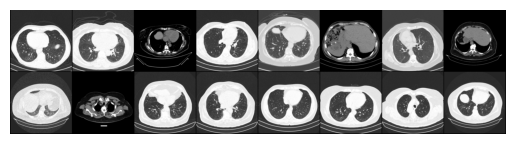

[0. 0. 0. 0. 1. 1. 1. 0.]


In [6]:
# Extract one batch from the validation dataloader
example_batchv = next(iter(vis_dataval))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same class of image, 
# If the label is 0, both images are the same class of image
concatenated = torch.cat((example_batchv[0], example_batchv[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batchv[2].numpy().reshape(-1))

In [7]:
# Image is normalized in the range [0, 1]
print(np.unique(example_batchv[0][0]))

[0.14901961 0.15294118 0.15686275 0.16078432 0.16470589 0.16862746
 0.17254902 0.1764706  0.18039216 0.18431373 0.1882353  0.19215687
 0.19607843 0.2        0.20392157 0.20784314 0.21176471 0.21568628
 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412 0.23921569
 0.24313726 0.24705882 0.2509804  0.25490198 0.25882354 0.2627451
 0.26666668 0.27058825 0.27450982 0.2784314  0.28235295 0.28627452
 0.2901961  0.29411766 0.29803923 0.3019608  0.30588236 0.30980393
 0.3137255  0.31764707 0.32156864 0.3254902  0.32941177 0.33333334
 0.3372549  0.34117648 0.34509805 0.34901962 0.3529412  0.35686275
 0.36078432 0.3647059  0.36862746 0.37254903 0.3764706  0.38039216
 0.38431373 0.3882353  0.39215687 0.39607844 0.4        0.40392157
 0.40784314 0.4117647  0.41568628 0.41960785 0.42352942 0.42745098
 0.43137255 0.43529412 0.4392157  0.44313726 0.44705883 0.4509804
 0.45490196 0.45882353 0.4627451  0.46666667 0.47058824 0.4745098
 0.47843137 0.48235294 0.4862745  0.49019608 0.49411765 0.4980392

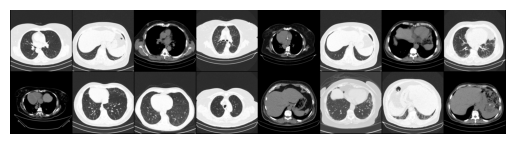

[0. 0. 1. 1. 0. 1. 0. 0.]


In [8]:
# Extract one batch from the training dataloader
example_batcht = next(iter(vis_datatrain))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same class of image, 
# If the label is 0, both images are the same class of image
concatenated = torch.cat((example_batcht[0], example_batcht[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batcht[2].numpy().reshape(-1))

<img src="images/loss_fnc.png" width="500" align="center"/>

<img src="images/siameses_example.PNG" width="600" align="center"/>

## Training the Siamese Network

In [9]:
# Load the training dataset
train_dataloader = DataLoader(siamese_datatrain,
                        shuffle=True,
                        num_workers=0, #8
                        batch_size=64)
# Load the validation dataset
val_dataloader = DataLoader(siamese_dataval,
                        shuffle=True,
                        num_workers=0, #8
                        batch_size=64)

dataloaders={'train': train_dataloader,
              'val': val_dataloader}

In [10]:
from utils.siamese_network import SiameseNetwork
from utils.loss_metrics import ContrastiveLoss
from utils.plot_helpers import plot_training_curves, compare_images

### Model VGG 16

In [11]:
# Create the network and move to gpu
net_vgg = SiameseNetwork(model_name="vgg16").to(device)
criterion = ContrastiveLoss().to(device)
optimizer_vgg = optim.Adam(net_vgg.parameters(), lr = 0.0001)
# Epochs to train for vgg y resnet
epochs = 60

In [12]:
# Train the model
model_vgg, metrics_vgg = net_vgg.train_eval(net_vgg,optimizer_vgg,
                                criterion,
                                dataloaders,
                                num_epochs = epochs)

Epoch 1/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 1/60 - Training acc: 0.524 - Training loss: 1.092 - Validation acc: 0.546 - Validation loss: 1.587


Epoch 2/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 2/60 - Training acc: 0.514 - Training loss: 1.108 - Validation acc: 0.556 - Validation loss: 1.340


Epoch 3/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 3/60 - Training acc: 0.532 - Training loss: 1.078 - Validation acc: 0.553 - Validation loss: 1.400


Epoch 4/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 4/60 - Training acc: 0.549 - Training loss: 1.045 - Validation acc: 0.741 - Validation loss: 1.149


Epoch 5/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 5/60 - Training acc: 0.621 - Training loss: 0.881 - Validation acc: 0.706 - Validation loss: 0.862


Epoch 6/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 6/60 - Training acc: 0.672 - Training loss: 0.764 - Validation acc: 0.771 - Validation loss: 0.616


Epoch 7/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 7/60 - Training acc: 0.739 - Training loss: 0.607 - Validation acc: 0.799 - Validation loss: 0.544


Epoch 8/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 8/60 - Training acc: 0.764 - Training loss: 0.518 - Validation acc: 0.792 - Validation loss: 0.503


Epoch 9/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 9/60 - Training acc: 0.767 - Training loss: 0.471 - Validation acc: 0.812 - Validation loss: 0.375


Epoch 10/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 10/60 - Training acc: 0.760 - Training loss: 0.464 - Validation acc: 0.799 - Validation loss: 0.349


Epoch 11/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 11/60 - Training acc: 0.782 - Training loss: 0.331 - Validation acc: 0.840 - Validation loss: 0.261


Epoch 12/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 12/60 - Training acc: 0.799 - Training loss: 0.306 - Validation acc: 0.802 - Validation loss: 0.278


Epoch 13/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 13/60 - Training acc: 0.782 - Training loss: 0.241 - Validation acc: 0.826 - Validation loss: 0.182


Epoch 14/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 14/60 - Training acc: 0.787 - Training loss: 0.222 - Validation acc: 0.901 - Validation loss: 0.143


Epoch 15/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 15/60 - Training acc: 0.770 - Training loss: 0.180 - Validation acc: 0.823 - Validation loss: 0.108


Epoch 16/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 16/60 - Training acc: 0.797 - Training loss: 0.154 - Validation acc: 0.850 - Validation loss: 0.086


Epoch 17/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 17/60 - Training acc: 0.770 - Training loss: 0.132 - Validation acc: 0.829 - Validation loss: 0.072


Epoch 18/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 18/60 - Training acc: 0.800 - Training loss: 0.109 - Validation acc: 0.823 - Validation loss: 0.069


Epoch 19/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 19/60 - Training acc: 0.780 - Training loss: 0.098 - Validation acc: 0.816 - Validation loss: 0.037


Epoch 20/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 20/60 - Training acc: 0.786 - Training loss: 0.098 - Validation acc: 0.826 - Validation loss: 0.048


Epoch 21/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 21/60 - Training acc: 0.776 - Training loss: 0.104 - Validation acc: 0.826 - Validation loss: 0.036


Epoch 22/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 22/60 - Training acc: 0.809 - Training loss: 0.081 - Validation acc: 0.843 - Validation loss: 0.039


Epoch 23/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 23/60 - Training acc: 0.799 - Training loss: 0.061 - Validation acc: 0.877 - Validation loss: 0.057


Epoch 24/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 24/60 - Training acc: 0.786 - Training loss: 0.069 - Validation acc: 0.829 - Validation loss: 0.032


Epoch 25/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 25/60 - Training acc: 0.823 - Training loss: 0.065 - Validation acc: 0.836 - Validation loss: 0.032


Epoch 26/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 26/60 - Training acc: 0.758 - Training loss: 0.098 - Validation acc: 0.809 - Validation loss: 0.037


Epoch 27/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 27/60 - Training acc: 0.794 - Training loss: 0.079 - Validation acc: 0.812 - Validation loss: 0.037


Epoch 28/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 28/60 - Training acc: 0.837 - Training loss: 0.068 - Validation acc: 0.809 - Validation loss: 0.032


Epoch 29/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 29/60 - Training acc: 0.805 - Training loss: 0.058 - Validation acc: 0.826 - Validation loss: 0.029


Epoch 30/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 30/60 - Training acc: 0.813 - Training loss: 0.060 - Validation acc: 0.870 - Validation loss: 0.013


Epoch 31/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 31/60 - Training acc: 0.797 - Training loss: 0.058 - Validation acc: 0.829 - Validation loss: 0.035


Epoch 32/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 32/60 - Training acc: 0.805 - Training loss: 0.057 - Validation acc: 0.819 - Validation loss: 0.048


Epoch 33/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 33/60 - Training acc: 0.790 - Training loss: 0.064 - Validation acc: 0.829 - Validation loss: 0.018


Epoch 34/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 34/60 - Training acc: 0.788 - Training loss: 0.064 - Validation acc: 0.823 - Validation loss: 0.034


Epoch 35/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 35/60 - Training acc: 0.788 - Training loss: 0.052 - Validation acc: 0.833 - Validation loss: 0.019


Epoch 36/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 36/60 - Training acc: 0.796 - Training loss: 0.049 - Validation acc: 0.775 - Validation loss: 0.037


Epoch 37/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 37/60 - Training acc: 0.817 - Training loss: 0.043 - Validation acc: 0.846 - Validation loss: 0.051


Epoch 38/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 38/60 - Training acc: 0.811 - Training loss: 0.055 - Validation acc: 0.860 - Validation loss: 0.042


Epoch 39/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 39/60 - Training acc: 0.790 - Training loss: 0.044 - Validation acc: 0.826 - Validation loss: 0.030


Epoch 40/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 40/60 - Training acc: 0.806 - Training loss: 0.042 - Validation acc: 0.840 - Validation loss: 0.022


Epoch 41/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 41/60 - Training acc: 0.817 - Training loss: 0.048 - Validation acc: 0.846 - Validation loss: 0.011


Epoch 42/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 42/60 - Training acc: 0.800 - Training loss: 0.043 - Validation acc: 0.795 - Validation loss: 0.030


Epoch 43/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 43/60 - Training acc: 0.824 - Training loss: 0.038 - Validation acc: 0.792 - Validation loss: 0.040


Epoch 44/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 44/60 - Training acc: 0.800 - Training loss: 0.035 - Validation acc: 0.836 - Validation loss: 0.020


Epoch 45/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 45/60 - Training acc: 0.842 - Training loss: 0.036 - Validation acc: 0.836 - Validation loss: 0.035


Epoch 46/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 46/60 - Training acc: 0.794 - Training loss: 0.050 - Validation acc: 0.826 - Validation loss: 0.016


Epoch 47/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 47/60 - Training acc: 0.804 - Training loss: 0.047 - Validation acc: 0.833 - Validation loss: 0.024


Epoch 48/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 48/60 - Training acc: 0.796 - Training loss: 0.039 - Validation acc: 0.853 - Validation loss: 0.021


Epoch 49/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 49/60 - Training acc: 0.836 - Training loss: 0.046 - Validation acc: 0.829 - Validation loss: 0.010


Epoch 50/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 50/60 - Training acc: 0.818 - Training loss: 0.038 - Validation acc: 0.805 - Validation loss: 0.027


Epoch 51/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 51/60 - Training acc: 0.811 - Training loss: 0.049 - Validation acc: 0.884 - Validation loss: 0.022


Epoch 52/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 52/60 - Training acc: 0.823 - Training loss: 0.036 - Validation acc: 0.823 - Validation loss: 0.028


Epoch 53/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 53/60 - Training acc: 0.799 - Training loss: 0.046 - Validation acc: 0.816 - Validation loss: 0.040


Epoch 54/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 54/60 - Training acc: 0.812 - Training loss: 0.037 - Validation acc: 0.850 - Validation loss: 0.020


Epoch 55/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 55/60 - Training acc: 0.824 - Training loss: 0.036 - Validation acc: 0.860 - Validation loss: 0.031


Epoch 56/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 56/60 - Training acc: 0.844 - Training loss: 0.033 - Validation acc: 0.850 - Validation loss: 0.031


Epoch 57/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 57/60 - Training acc: 0.821 - Training loss: 0.041 - Validation acc: 0.846 - Validation loss: 0.037


Epoch 58/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 58/60 - Training acc: 0.800 - Training loss: 0.034 - Validation acc: 0.867 - Validation loss: 0.029


Epoch 59/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 59/60 - Training acc: 0.828 - Training loss: 0.036 - Validation acc: 0.792 - Validation loss: 0.028


Epoch 60/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

Epoch 60/60 - Training acc: 0.799 - Training loss: 0.034 - Validation acc: 0.823 - Validation loss: 0.027


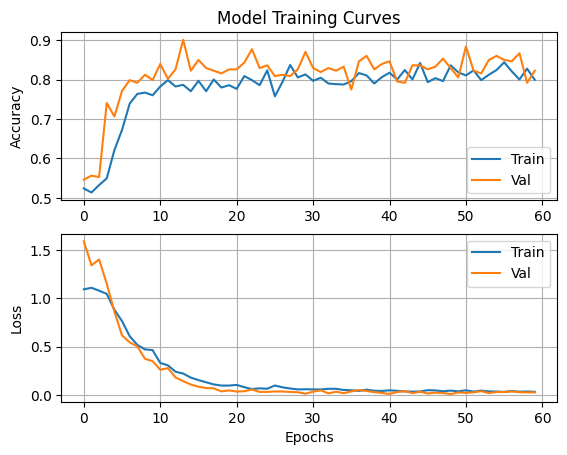

In [13]:
plot_training_curves(metrics_vgg)

In [14]:
model_path = 'trainded_models/model_60vgg_no_norm.pth'
torch.save(model_vgg.state_dict(),model_path)

### Model ResNet 50

In [15]:
net_resnet = SiameseNetwork(model_name="resnet50").to(device)
criterion = ContrastiveLoss().to(device)
optimizer_resnet = optim.Adam(net_resnet.parameters(), lr = 0.0001)

In [16]:
# Train the model
model_resnet, metrics_resnet = net_resnet.train_eval(net_resnet,optimizer_resnet,
                                criterion,
                                dataloaders,
                                num_epochs = epochs)

Epoch 1/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 1/60 - Training acc: 0.530 - Training loss: 1.189 - Validation acc: 0.519 - Validation loss: 1.154


Epoch 2/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 2/60 - Training acc: 0.526 - Training loss: 0.828 - Validation acc: 0.553 - Validation loss: 0.897


Epoch 3/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 3/60 - Training acc: 0.670 - Training loss: 0.522 - Validation acc: 0.669 - Validation loss: 0.458


Epoch 4/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 4/60 - Training acc: 0.707 - Training loss: 0.355 - Validation acc: 0.823 - Validation loss: 0.316


Epoch 5/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 5/60 - Training acc: 0.805 - Training loss: 0.235 - Validation acc: 0.843 - Validation loss: 0.216


Epoch 6/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 6/60 - Training acc: 0.845 - Training loss: 0.178 - Validation acc: 0.887 - Validation loss: 0.119


Epoch 7/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 7/60 - Training acc: 0.858 - Training loss: 0.120 - Validation acc: 0.877 - Validation loss: 0.108


Epoch 8/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 8/60 - Training acc: 0.848 - Training loss: 0.109 - Validation acc: 0.850 - Validation loss: 0.075


Epoch 9/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 9/60 - Training acc: 0.828 - Training loss: 0.097 - Validation acc: 0.867 - Validation loss: 0.069


Epoch 10/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 10/60 - Training acc: 0.828 - Training loss: 0.067 - Validation acc: 0.860 - Validation loss: 0.053


Epoch 11/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 11/60 - Training acc: 0.855 - Training loss: 0.064 - Validation acc: 0.870 - Validation loss: 0.080


Epoch 12/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 12/60 - Training acc: 0.834 - Training loss: 0.056 - Validation acc: 0.908 - Validation loss: 0.057


Epoch 13/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 13/60 - Training acc: 0.876 - Training loss: 0.051 - Validation acc: 0.891 - Validation loss: 0.048


Epoch 14/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 14/60 - Training acc: 0.870 - Training loss: 0.049 - Validation acc: 0.884 - Validation loss: 0.035


Epoch 15/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 15/60 - Training acc: 0.865 - Training loss: 0.045 - Validation acc: 0.863 - Validation loss: 0.053


Epoch 16/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 16/60 - Training acc: 0.860 - Training loss: 0.042 - Validation acc: 0.874 - Validation loss: 0.057


Epoch 17/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 17/60 - Training acc: 0.875 - Training loss: 0.033 - Validation acc: 0.898 - Validation loss: 0.025


Epoch 18/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 18/60 - Training acc: 0.881 - Training loss: 0.045 - Validation acc: 0.891 - Validation loss: 0.030


Epoch 19/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 19/60 - Training acc: 0.864 - Training loss: 0.041 - Validation acc: 0.932 - Validation loss: 0.025


Epoch 20/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 20/60 - Training acc: 0.881 - Training loss: 0.047 - Validation acc: 0.911 - Validation loss: 0.042


Epoch 21/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 21/60 - Training acc: 0.882 - Training loss: 0.030 - Validation acc: 0.867 - Validation loss: 0.044


Epoch 22/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 22/60 - Training acc: 0.874 - Training loss: 0.036 - Validation acc: 0.928 - Validation loss: 0.025


Epoch 23/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 23/60 - Training acc: 0.906 - Training loss: 0.033 - Validation acc: 0.956 - Validation loss: 0.037


Epoch 24/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 24/60 - Training acc: 0.901 - Training loss: 0.032 - Validation acc: 0.966 - Validation loss: 0.023


Epoch 25/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 25/60 - Training acc: 0.897 - Training loss: 0.029 - Validation acc: 0.939 - Validation loss: 0.034


Epoch 26/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 26/60 - Training acc: 0.927 - Training loss: 0.029 - Validation acc: 0.945 - Validation loss: 0.030


Epoch 27/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 27/60 - Training acc: 0.895 - Training loss: 0.025 - Validation acc: 0.945 - Validation loss: 0.030


Epoch 28/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 28/60 - Training acc: 0.900 - Training loss: 0.036 - Validation acc: 0.898 - Validation loss: 0.034


Epoch 29/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 29/60 - Training acc: 0.892 - Training loss: 0.031 - Validation acc: 0.898 - Validation loss: 0.021


Epoch 30/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 30/60 - Training acc: 0.898 - Training loss: 0.028 - Validation acc: 0.939 - Validation loss: 0.028


Epoch 31/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 31/60 - Training acc: 0.892 - Training loss: 0.027 - Validation acc: 0.962 - Validation loss: 0.033


Epoch 32/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 32/60 - Training acc: 0.907 - Training loss: 0.030 - Validation acc: 0.942 - Validation loss: 0.034


Epoch 33/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 33/60 - Training acc: 0.922 - Training loss: 0.023 - Validation acc: 0.932 - Validation loss: 0.047


Epoch 34/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 34/60 - Training acc: 0.924 - Training loss: 0.025 - Validation acc: 0.904 - Validation loss: 0.044


Epoch 35/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 35/60 - Training acc: 0.911 - Training loss: 0.025 - Validation acc: 0.945 - Validation loss: 0.029


Epoch 36/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 36/60 - Training acc: 0.928 - Training loss: 0.024 - Validation acc: 0.932 - Validation loss: 0.037


Epoch 37/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 37/60 - Training acc: 0.936 - Training loss: 0.021 - Validation acc: 1.003 - Validation loss: 0.030


Epoch 38/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 38/60 - Training acc: 0.935 - Training loss: 0.024 - Validation acc: 0.956 - Validation loss: 0.044


Epoch 39/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 39/60 - Training acc: 0.935 - Training loss: 0.019 - Validation acc: 0.956 - Validation loss: 0.054


Epoch 40/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 40/60 - Training acc: 0.941 - Training loss: 0.028 - Validation acc: 0.962 - Validation loss: 0.030


Epoch 41/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 41/60 - Training acc: 0.937 - Training loss: 0.025 - Validation acc: 0.976 - Validation loss: 0.022


Epoch 42/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 42/60 - Training acc: 0.940 - Training loss: 0.023 - Validation acc: 0.973 - Validation loss: 0.029


Epoch 43/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 43/60 - Training acc: 0.943 - Training loss: 0.019 - Validation acc: 0.997 - Validation loss: 0.053


Epoch 44/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 44/60 - Training acc: 0.952 - Training loss: 0.021 - Validation acc: 0.945 - Validation loss: 0.036


Epoch 45/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 45/60 - Training acc: 0.956 - Training loss: 0.015 - Validation acc: 0.976 - Validation loss: 0.033


Epoch 46/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 46/60 - Training acc: 0.945 - Training loss: 0.034 - Validation acc: 0.980 - Validation loss: 0.020


Epoch 47/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 47/60 - Training acc: 0.948 - Training loss: 0.021 - Validation acc: 0.969 - Validation loss: 0.030


Epoch 48/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 48/60 - Training acc: 0.948 - Training loss: 0.023 - Validation acc: 0.962 - Validation loss: 0.032


Epoch 49/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 49/60 - Training acc: 0.954 - Training loss: 0.017 - Validation acc: 0.976 - Validation loss: 0.017


Epoch 50/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 50/60 - Training acc: 0.950 - Training loss: 0.028 - Validation acc: 0.973 - Validation loss: 0.028


Epoch 51/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 51/60 - Training acc: 0.967 - Training loss: 0.021 - Validation acc: 0.942 - Validation loss: 0.022


Epoch 52/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 52/60 - Training acc: 0.937 - Training loss: 0.013 - Validation acc: 0.990 - Validation loss: 0.018


Epoch 53/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 53/60 - Training acc: 0.951 - Training loss: 0.022 - Validation acc: 0.959 - Validation loss: 0.045


Epoch 54/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 54/60 - Training acc: 0.945 - Training loss: 0.021 - Validation acc: 0.986 - Validation loss: 0.023


Epoch 55/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 55/60 - Training acc: 0.967 - Training loss: 0.017 - Validation acc: 0.976 - Validation loss: 0.047


Epoch 56/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 56/60 - Training acc: 0.961 - Training loss: 0.028 - Validation acc: 0.973 - Validation loss: 0.030


Epoch 57/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 57/60 - Training acc: 0.948 - Training loss: 0.028 - Validation acc: 0.969 - Validation loss: 0.029


Epoch 58/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 58/60 - Training acc: 0.943 - Training loss: 0.017 - Validation acc: 0.969 - Validation loss: 0.026


Epoch 59/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 59/60 - Training acc: 0.956 - Training loss: 0.023 - Validation acc: 0.986 - Validation loss: 0.021


Epoch 60/60 - val: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

Epoch 60/60 - Training acc: 0.949 - Training loss: 0.018 - Validation acc: 0.997 - Validation loss: 0.025


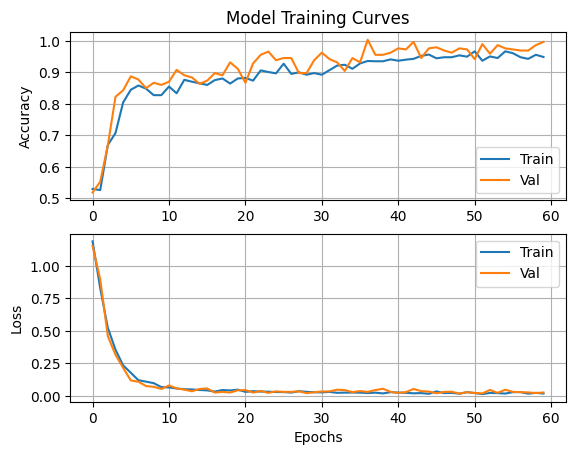

In [17]:
plot_training_curves(metrics_resnet)

In [18]:
model_path = 'trainded_models/model_60resnet_no_norm.pth'
torch.save(model_resnet.state_dict(),model_path)

In [ ]:
# model_path = 'trainded_models/model_100_4C.pth'
# model = SiameseNetwork()
# model.load_state_dict(torch.load(model_path))
# model.eval().to(device)

In [ ]:
#print(next(model.parameters()).device)

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
test_transformation = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                          std=[0.229, 0.224, 0.225])
                                     ])

folder_test = SiameseNetworkDataset(root_path=os.path.join('dataset_jpg1','test'), transform=test_transformation)


test_dataloader = DataLoader(folder_test, num_workers=0, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)

# First image
x0, _, _ = next(dataiter)
x0 = x0.to(device)

class_names = ["fibrose", "pines", "reabsorcao", "vias aereas"]
Norm = Sigmoid() # Normalization function to [0,1]

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)
    x1 = x1.to(device)
    
    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = model(x0, x1)
    _, idx_1 = torch.max(output1,1)
    _, idx_2 = torch.max(output2,1)
    
    images_classes = [class_names[idx_1[0]], class_names[idx_2[0]]]
    
    # Calculate the euclidean distance between the two images
    euclidean_distance = F.pairwise_distance(output1, output2)
    # Plot the images and the distance between them
    compare_images(x0[0], x1[0], images_classes, f'Dissimilarity: {euclidean_distance.item():.2f}') 

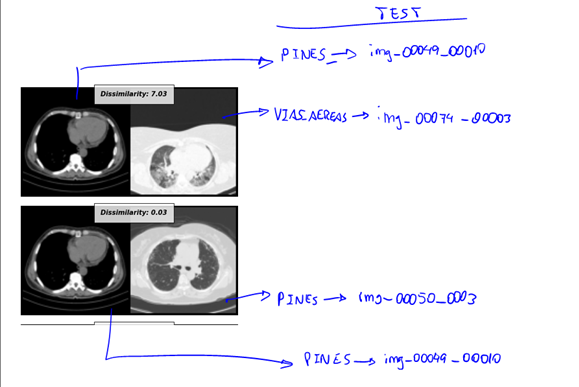

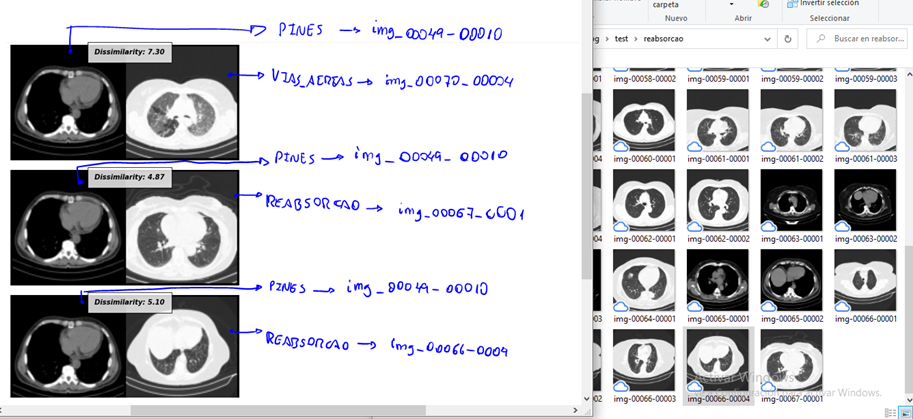

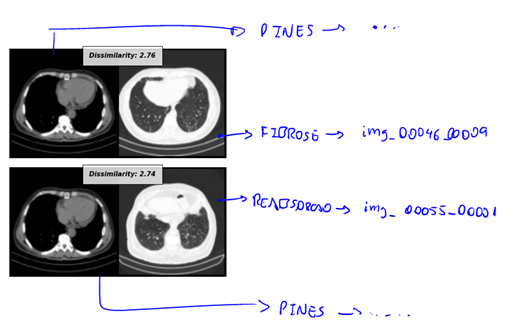